# Basic Tutorial: `GaussLineNoise`

Trey V. Wenger (c) August 2024

This notebook is nearly identical to the basic tutorial, except we implement a new model called `GaussNoiseModel`. This model allows the spectral rms to be an inferred parameter. Such is a useful trick for complicated posterior distributions, such as when there are multiple, high signal-to-noise components.

In [1]:
# General imports    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.4.3+8.g2908c9c.dirty


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Text(0, 0.5, 'Brightness Temperature (K)')

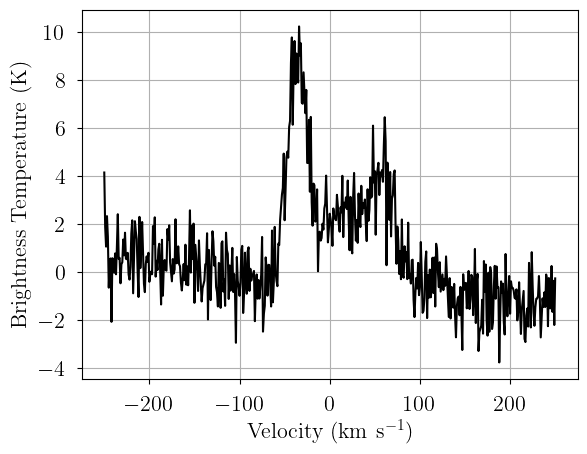

In [3]:
from bayes_spec.models import GaussNoiseModel

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "observation_baseline_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `bayes_spec`.

We begin with a three-cloud (`n_cloud=3`) model, with a 2nd order polynomial baseline (`baseline_degree=2`).

In [5]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

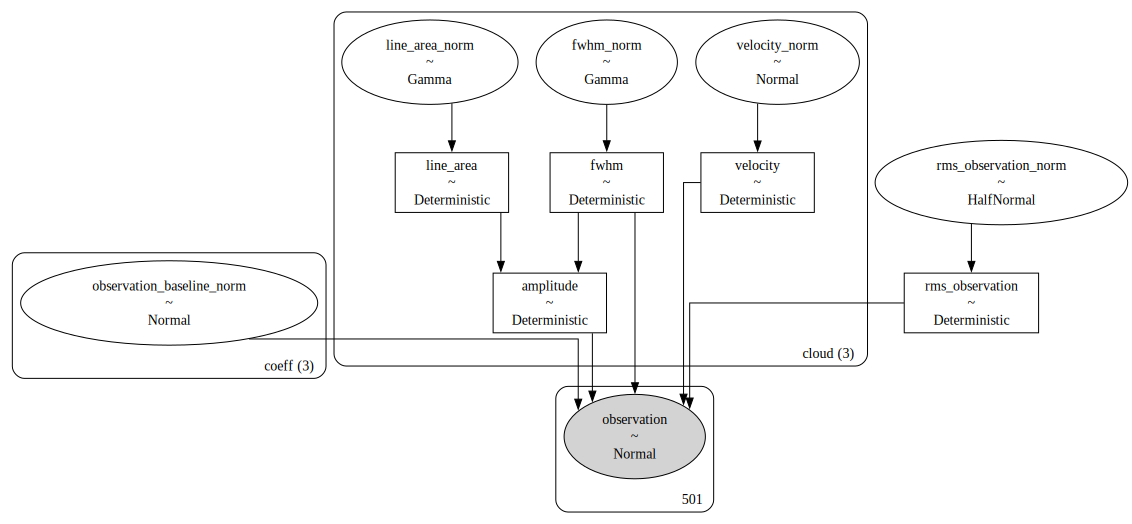

In [6]:
# Plot model graph
model.graph()

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, rms_observation_norm, velocity_norm]


array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

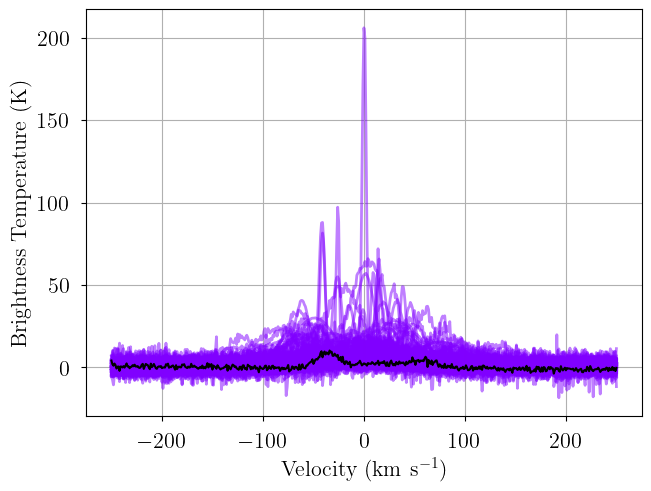

In [7]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
plot_predictive(model.data, prior.prior_predictive)

## Posterior Sampling: MCMC

In [8]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 1,062.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [9]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [10]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],8.781,0.396,8.054,9.533,0.010,0.007,1655.0,2845.0,1.00
amplitude[1],3.577,0.750,2.382,4.919,0.028,0.020,754.0,2176.0,1.00
amplitude[2],3.052,0.238,2.610,3.511,0.005,0.003,2431.0,3180.0,1.00
fwhm[0],24.754,1.196,22.497,27.024,0.026,0.019,2125.0,2342.0,1.00
fwhm[1],30.807,5.844,20.446,41.285,0.208,0.147,831.0,1990.0,1.00
fwhm[2],73.811,18.199,40.624,102.365,0.730,0.516,669.0,1291.0,1.01
fwhm_norm[0],0.825,0.040,0.750,0.901,0.001,0.001,2125.0,2342.0,1.00
fwhm_norm[1],1.027,0.195,0.682,1.376,0.007,0.005,831.0,1990.0,1.00
fwhm_norm[2],2.460,0.607,1.354,3.412,0.024,0.017,669.0,1291.0,1.01
line_area[0],231.438,15.994,204.375,263.560,0.476,0.340,1173.0,1834.0,1.00


Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

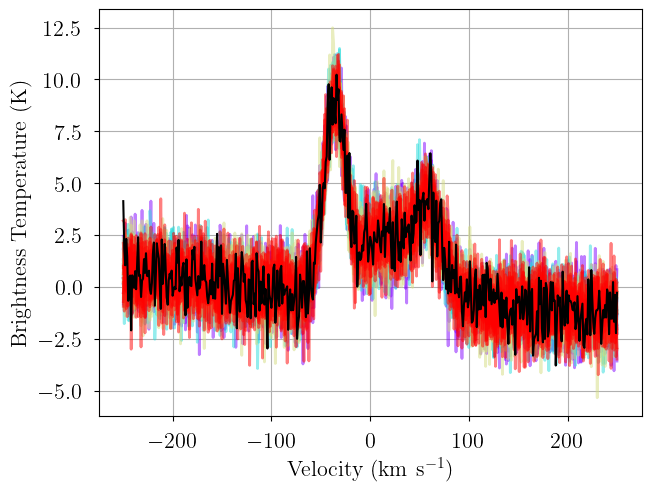

In [11]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

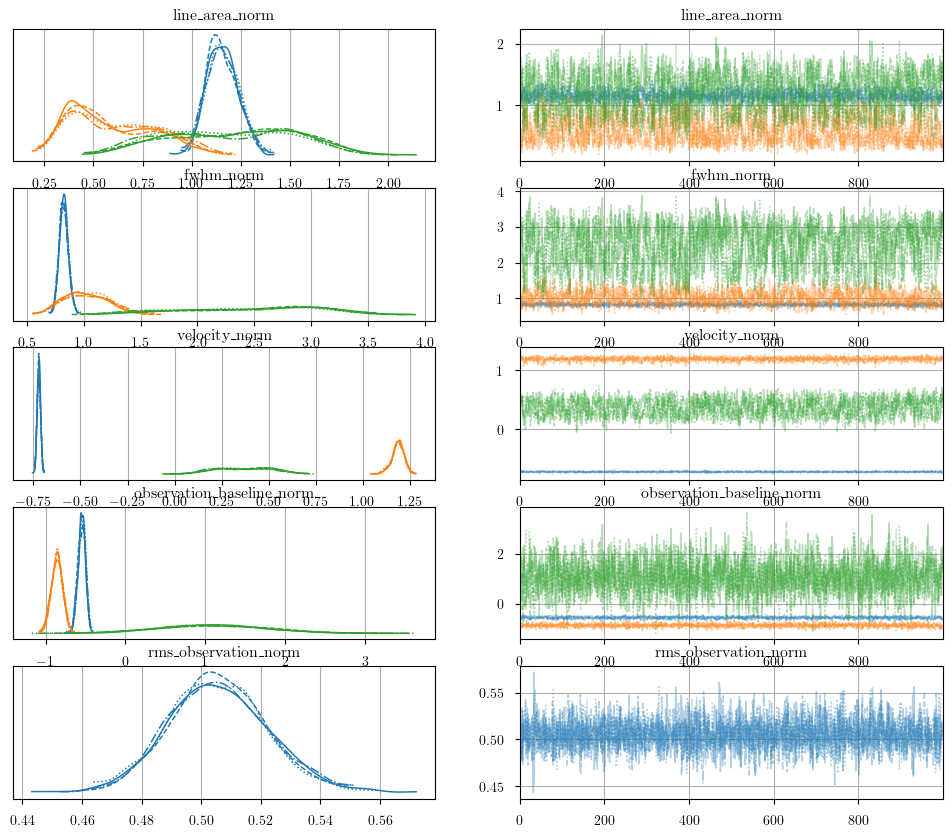

In [12]:
from bayes_spec.plots import plot_traces

plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)